In [2]:
'''download if not installed'''
#!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=bf7faa65f16d3163c8a232d62276f2b96160955b2f0c434bfbcf6c32168edcc5
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [3]:
import tensorflow as tf
import datetime, os
#hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns
import codecs, json
import math
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)
import random
import datetime
import shutil
print("TensorFlow version: {}".format(tf.__version__))
import random

TensorFlow version: 2.18.0


In [4]:
# define  Collocations points
N_ini = 10000   #Total number of data points for 'u': IC
N_f   = 10000   #Total number of collocation points : domain
N_obs = 100   # Total number of observation points (if applicable)
N_b   = 640     # Total number of data points for 'u': boundary BC

In [5]:
N_t_x=N_obs
x=np.linspace(0, 1, N_t_x)
x=np.expand_dims(x, axis=1)

y=np.linspace(0, 1, N_t_x)
y=np.expand_dims(y, axis=1)


t=np.linspace(0, 1, N_t_x)
t=np.expand_dims(t, axis=1)

X, Y, T = np.meshgrid(x,y,t)                         # makes 3 arrays X, Y and T such that u(X[i],Y[j],T[k])=usol[i][j][k] are a tuple
lb = np.array([x.min(), y.min(), t.min()])  # Domain bounds
ub = np.array([x.max(), y.max(), t.max()])  # Domain bounds


x_b = np.linspace(0, 1, N_b)
x_b = np.expand_dims(x_b, axis=1)
y_b = np.linspace(0, 1, N_b)
y_b = np.expand_dims(y_b, axis=1)
left_boundary  = np.array(np.hstack([np.full_like(y_b, x_b.min()), y_b]))
right_boundary = np.array(np.hstack([np.full_like(y_b, x_b.max()), y_b]))
upper_boundary = np.array(np.hstack([x_b, np.full_like(x_b, y_b.max())]))
lower_boundary = np.array(np.hstack([x_b, np.full_like(x_b, y_b.min())]))

tb=np.linspace(0, 1, N_b)
tb=np.expand_dims(tb, axis=1)
idx_t = np.random.choice(tb.shape[0], N_b, replace=False)
tb = tb[idx_t,:]
X_flat = X.flatten()
Y_flat = Y.flatten()
T_flat = T.flatten()
# print(Y.shape)
# print(Y_flat.shape)

In [6]:
def set_train_data(N_ini,N_f,tb):
    # Initial Condition -1 =< x =<1, -1 =< y =<1 and t = 0
    # Create a grid of points for the initial condition
    x_flat = X[0,:][:,0][:,None].flatten() # Get the flattened x coordinates at t=0
    y_flat = Y[:,0][:,0][:,None].flatten() # Get the flattened y coordinates at t=0
    X_grid, Y_grid = np.meshgrid(x_flat, y_flat)

    # Calculate the initial condition values on this grid
    U_grid = np.sin(4*np.pi*X_grid) * np.cos(4*np.pi*Y_grid)

    # Flatten the grid coordinates and values
    X_ini_coords = X_grid.flatten()[:,None]
    Y_ini_coords = Y_grid.flatten()[:,None]
    T_ini_coords = np.zeros_like(X_ini_coords) # Time is 0 for initial condition
    U_ini_values = U_grid.flatten()[:,None]


    # Combine coordinates into a single array
    all_ini_points = np.hstack((X_ini_coords, Y_ini_coords, T_ini_coords))

    # Combine coordinates and u values
    all_ini_data = np.hstack((all_ini_points, U_ini_values))

    # Randomly sample N_ini points from the initial condition data
    # Use replace=False to get unique sample points
    idx_ini = np.random.choice(all_ini_data.shape[0], N_ini, replace=False)
    ini_sampled_data = all_ini_data[idx_ini, :]

    X_ini_train = ini_sampled_data[:, :3] # The first 3 columns are x, y, t
    u_ini_train = ini_sampled_data[:, 3:] # The last column is u

    # just for ploting the initial condition
    u_plot = all_ini_data[:,3:]
    u_plot = u_plot.reshape(X.shape[0],-1)


    # Latin Hypercube sampling for collocation points
    # N_f sets of tuples(x,y,t)
    X_f_train = lb + (ub-lb)*lhs(3,N_f)

    #Boundary Condition x = -1, y = 1 and 0 =< t =<1
    X_left_boundary_train = np.concatenate((0*tb + left_boundary, tb), 1)

    #Boundary Condition x = 1, y = 1 and 0 =< t =<1
    X_right_boundary_train = np.concatenate((0*tb + right_boundary, tb), 1)

    #Boundary Condition x = -1, y = -1 and 0 =< t =<1
    X_upper_boundary_train = np.concatenate((0*tb + upper_boundary, tb), 1)

    #Boundary Condition x = 1, y = -1 and 0 =< t =<1
    X_lower_boundary_train = np.concatenate((0*tb + lower_boundary, tb), 1)


    print('X_f_train: {0}, X_ini_train: {1}, X_upper_boundary_train: {2}, X_lower_boundary_train: {3}, X_left_boundary_train: {4}, X_right_boundary_train:{5}, u_ini_train: {6}'.format(X_f_train.shape,\
    X_ini_train.shape, X_upper_boundary_train.shape, X_lower_boundary_train.shape, X_left_boundary_train.shape, X_right_boundary_train.shape, u_ini_train.shape))

    return X_f_train, X_ini_train, X_left_boundary_train, X_right_boundary_train, X_upper_boundary_train, X_lower_boundary_train, u_ini_train, u_plot

In [14]:
X_f_train, X_ini_train, X_left_boundary_train, X_right_boundary_train, X_upper_boundary_train, X_lower_boundary_train, u_ini_train, u_plot = set_train_data(N_ini,N_f,tb)
X_u_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))

X_f_train: (10000, 3), X_ini_train: (10000, 3), X_upper_boundary_train: (640, 3), X_lower_boundary_train: (640, 3), X_left_boundary_train: (640, 3), X_right_boundary_train:(640, 3), u_ini_train: (10000, 1)


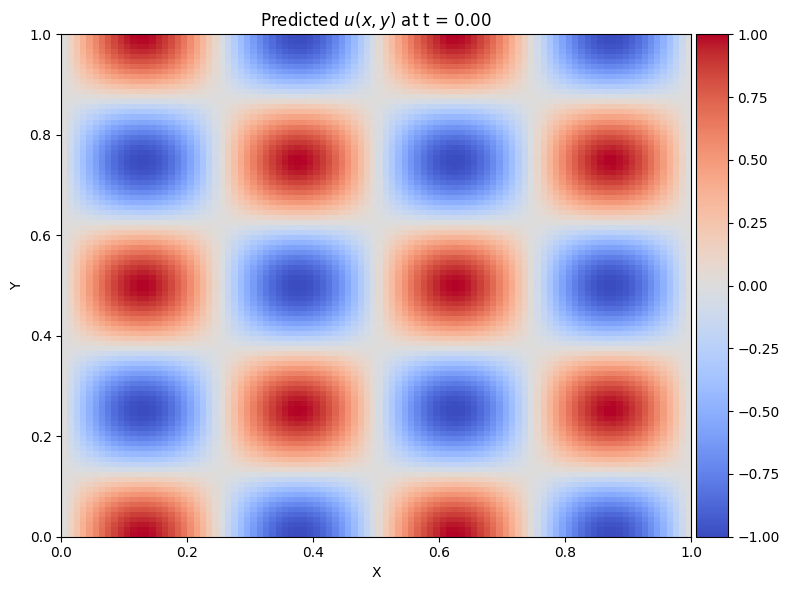

In [8]:
fig = plt.figure(figsize=(8, 6))
ax= fig.add_subplot(111)
time_value = X_ini_train[:,2][0]


h = ax.imshow(u_plot, interpolation='nearest', cmap='coolwarm',
                      extent=[lb[1], ub[1], lb[0], ub[0]], # Extent is [y_min, y_max, x_min, x_max]
                      origin='lower', aspect='auto', vmin=-1, vmax=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Predicted $u(x, y)$ at t = {time_value:.2f}')

plt.tight_layout()
plt.show()

/tmp/ipython-input-1038274154.py:54: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for the title


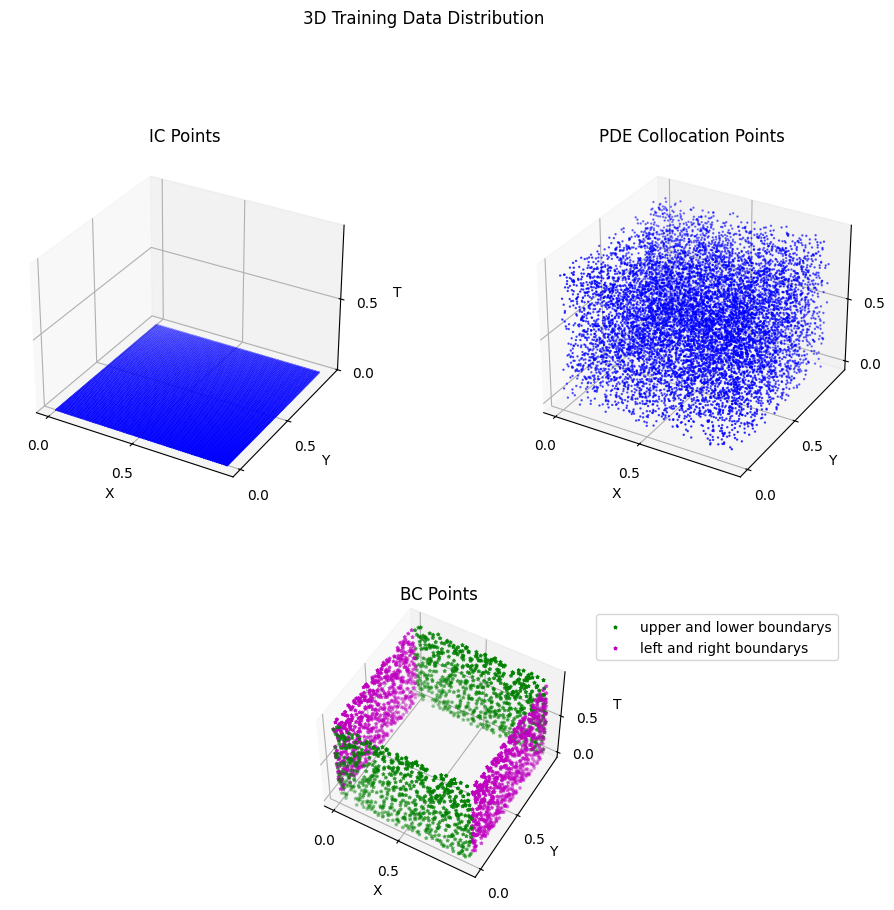

In [9]:
fig = plt.figure(figsize=(12, 10))
ax1= fig.add_subplot(221, projection='3d')
ax2= fig.add_subplot(222, projection='3d')
ax3= fig.add_subplot(235, projection='3d')


# Define tick locations
x_ticks = np.arange(lb[0], ub[0], 0.5)
y_ticks = np.arange(lb[1], ub[1], 0.5)
t_ticks = np.arange(lb[2], ub[2], 0.5)

# Scatter plot of initial condition points
ax1.scatter(X_ini_train[:,0], X_ini_train[:,1], X_ini_train[:,2], c='b', marker='*', s=0.5)
ax1.set_zlim(0, 1) # Set z-axis limits for ax1
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('T')
ax1.set_title('IC Points')
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_zticks(t_ticks)


# Scatter plot of PDE collocation points
ax2.scatter(X_f_train[:,0], X_f_train[:,1], X_f_train[:,2], c='b', marker='o', s=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('T')
ax2.set_title('PDE Collocation Points')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_zticks(t_ticks)


# Scatter plot of lower boundary condition points
ax3.scatter(X_upper_boundary_train[:,0], X_upper_boundary_train[:,1], X_upper_boundary_train[:,2], c='g', marker='*', s=5, label="upper and lower boundarys")
ax3.scatter(X_lower_boundary_train[:,0], X_lower_boundary_train[:,1], X_lower_boundary_train[:,2], c='g', marker='*', s=5)

ax3.scatter(X_left_boundary_train[:,0], X_left_boundary_train[:,1], X_left_boundary_train[:,2], c='m', marker='*', s=5, label="left and right boundarys")
ax3.scatter(X_right_boundary_train[:,0], X_right_boundary_train[:,1], X_right_boundary_train[:,2], c='m', marker='*', s=5)

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('T')
ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) # Changed legend location to outside upper left
ax3.set_title('BC Points')
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_zticks(t_ticks)
ax3.view_init(elev=50) # Rotate ax3


fig.suptitle('3D Training Data Distribution', y=1.02) # Add a main title to the figure
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for the title
plt.show()

In [10]:
def EraseFile(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [11]:
pathOutput = os.getcwd() + '/save_figs'
if not os.path.isdir(pathOutput):
    os.mkdir(pathOutput)

In [12]:
class Sequentialmodel(tf.Module):
    def __init__(self, layers, name=None):

        ###############################################
        self.X_f   = tf.constant(X_f_train, dtype=tf.float64)
        self.X_ini = tf.constant(X_ini_train, dtype=tf.float64)
        self.X_upper_boundary  = tf.constant(X_upper_boundary_train, dtype=tf.float64)
        self.X_lower_boundary = tf.constant(X_lower_boundary_train, dtype=tf.float64)
        self.X_left_boundary  = tf.constant(X_left_boundary_train, dtype=tf.float64)
        self.X_right_boundary = tf.constant(X_right_boundary_train, dtype=tf.float64)
        self.u_ini = tf.constant(u_ini_train, dtype=tf.float64)
        ###############################################


        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters

        for i in range(len(layers)-1):

            input_dim = layers[i]
            output_dim = layers[i+1]

            #Xavier standard deviation
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = tf.float64) * std_dv

            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = tf.float64), trainable = True, name = 'b' + str(i+1))

            self.W.append(w)
            self.W.append(b)

            self.parameters +=  input_dim * output_dim + output_dim

        ###############################################
        # Define the Adam optimizer
        self.optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
        """
        # Define the Scipy L-BFGS-B optimizer
        self.scipy_optimizer=scipy.optimize(fun = self.optimizerfunc,
                                          x0 = init_params,
                                          args=(),
                                          method='L-BFGS-B',
                                          jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                          callback = PINN.optimizer_callback,
                                          options = {'disp': None,
                                                    'maxcor': 200,
                                                    'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                                    'gtol': 5e-8,
                                                    'maxfun':  100,
                                                    'maxiter': 100,
                                                    'iprint': -1,   #print update every 50 iterations
                                                    'maxls': 50})
        """

    ###############################################
    """
    def evaluate(self,x):

        x = (x-lb)/(ub-lb)
        a = x

        for i in range(len(layers)-2):
            a = tf.expand_dims(a, axis=0)
            a = tf.keras.layers.LSTM(units=layers[i+1], return_sequences=True, activation='tanh')(a)
            a = tf.squeeze(a, axis=0)

        a = tf.matmul(a, self.W[-2]) + self.W[-1] # For regression, no activation to last layer
        return a
    """
    ###############################################

    def evaluate(self,x_input):
        # Ensure input is float64
        x_input = tf.cast(x_input, dtype=tf.float64)

        x = x_input[:,0:1]
        y = x_input[:,1:2]
        t = x_input[:,2:3]

        # Ensure lb and ub are float64 tensors for consistent operations
        lb_tf = tf.constant(lb, dtype=tf.float64)
        ub_tf = tf.constant(ub, dtype=tf.float64)

        # Normalization with correct slicing and broadcasting
        x_normalized = (x - lb_tf[0:1]) / (ub_tf[0:1] - lb_tf[0:1])
        y_normalized = (y - lb_tf[1:2]) / (ub_tf[1:2] - lb_tf[1:2])
        t_normalized = (t - lb_tf[2:3]) / (ub_tf[2:3] - lb_tf[2:3])


        a = tf.concat([x_normalized, y_normalized, t_normalized], axis=1)

        for i in range(len(layers)-2):
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)

        # Output layer
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1])
        return a

    ###############################################
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array

        for i in range (len(layers)-1):

            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases

            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases

        return parameters_1d
    ###############################################
    def set_weights(self,parameters):
        parameters = tf.cast(parameters, dtype=tf.float64)
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor

            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor

            pick_w = parameters[0:size_w] #pick the weights
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign
            parameters = parameters[size_w:] #delete

            pick_b = parameters[0:size_b] #pick the biases
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign
            parameters = parameters[size_b:] #delete
    ###############################################
    def loss_IC(self,x_ini,u_ini):
        loss_IC = tf.reduce_mean(tf.square(u_ini-self.evaluate(x_ini)))
        return loss_IC
    ###############################################
    def loss_BC(self, x_upper_boundary, x_lower_boundary, x_left_boundary, x_right_boundary):

        pred_upper_boundary = self.evaluate(x_upper_boundary)
        pred_lower_boundary = self.evaluate(x_lower_boundary)

        pred_left_boundary = self.evaluate(x_left_boundary)
        pred_right_boundary = self.evaluate(x_right_boundary)

        loss_1 =  tf.reduce_mean(tf.square(pred_upper_boundary - pred_lower_boundary))
        loss_2 = tf.reduce_mean(tf.square(pred_left_boundary - pred_right_boundary))

        loss_u = loss_1 + loss_2
        return loss_u
    ###############################################
    def loss_PDE(self, X_f):

        g = tf.Variable(X_f, dtype = 'float64', trainable = False)

        x_f = g[:,0:1]
        y_f = g[:,1:2]
        t_f = g[:,2:3]
        #print("x_f.shape,t_f.shape :",t_f.shape,t_f.shape)

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(y_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0]], axis=1)
            #print("g.shape :",g.shape)

            u = self.evaluate(g)
            u_x = tape.gradient(u,x_f)
            u_y = tape.gradient(u,y_f)

        u_t = tape.gradient(u,t_f)
        u_xx = tape.gradient(u_x, x_f)
        u_yy = tape.gradient(u_y, y_f)

        del tape


        # The PDE is u_t - 0.0001 * (u_xx + u_yy) + u^3 - u = 0
        f = u_t - 0.0001 * (u_xx + u_yy) + u**3 - u

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    ###############################################
    def loss(self,xf,x_ini,x_upper_boundary,x_lower_boundary,x_left_boundary,x_right_boundary,u_ini):

        loss_IC = self.loss_IC(x_ini,u_ini)

        loss_f =self.loss_PDE(xf)
        loss_BC = self.loss_BC(x_upper_boundary, x_lower_boundary, x_left_boundary, x_right_boundary)
        loss = loss_IC + loss_BC+ loss_f

        return loss, loss_BC,loss_IC, loss_f
    ###############################################
    def optimizerfunc(self,parameters):

        self.set_weights(parameters)

        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)

            loss_val, loss_BC, loss_IC, loss_f = self.loss(self.X_f,self.X_ini,self.X_upper_boundary,self.X_lower_boundary,self.X_left_boundary,self.X_right_boundary,self.u_ini)
        grads = tape.gradient(loss_val,self.trainable_variables)

        # Convert gradients to numpy array and flatten
        grads_flat = tf.concat([tf.reshape(grad, [-1]) for grad in grads], axis=0)


        return loss_val.numpy(), grads_flat.numpy()
    ###############################################
    def print_final_loss(self,x):
        # Wrap the original callback function to print the final loss value
        def wrapped_callback(x):
            if not wrapped_callback.done:
                self.optimizer_callback(x)
                wrapped_callback.done = True

        wrapped_callback.done = False
        results = self.optimizer_callback(x)

        # Print the final loss value

        tf.print(results.fun)

        return results
    ###############################################
    def save_predictions(self, epoch,pathOutput,X_u_test,\
                         X_ini,u_ini,N_b,epoch_print):
        if (epoch + 1) % epoch_print == 0:
            # Need to evaluate on the full test set X_u_test, not a batch
            u_pred = self.evaluate(X_u_test)

            x_test_plot = np.linspace(lb[0], ub[0], 100) # 100 points for x
            y_test_plot = np.linspace(lb[1], ub[1], 100) # 100 points for y
            #t_test_plot = np.linspace(lb[2], ub[2], 100) # 100 points for t
            t_fixed_plot = 0.5

            X_plot, Y_plot = np.meshgrid(x_test_plot, y_test_plot)
            T_plot = np.full_like(X_plot, t_fixed_plot) # Create a Y grid with the fixed value

            X_test_plot_flat = X_plot.flatten()[:,None]
            Y_test_plot_flat = Y_plot.flatten()[:,None]
            T_test_plot_flat = T_plot.flatten()[:,None]

            X_test_plot_3D = np.hstack((X_test_plot_flat, Y_test_plot_flat, T_test_plot_flat))

            u_pred_plot = self.evaluate(X_test_plot_3D)
            u_pred_plot_reshaped = np.reshape(u_pred_plot, (100, 100)).T

            #------------------------------------
            # plot
            fig, ax = plt.subplots(figsize=(10, 8))
            gs0 = gridspec.GridSpec(1, 2)
            gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
            ax = plt.subplot(gs0[:, :])

            h = ax.imshow(u_pred_plot_reshaped, interpolation='nearest', cmap='coolwarm',
                        extent=[y_test_plot.min(), y_test_plot.max(), x_test_plot.min(), x_test_plot.max()],
                        origin='lower', aspect='auto')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(h, cax=cax)

            ax.set_xlabel('$y$')
            ax.set_ylabel('$x$')
            ax.set_title(r'$\phi(x, y)$ Prediction at $t=0.5$', fontsize = 10)

            # Plot slices at different times (matching the original solutionplot)
            gs1 = gridspec.GridSpec(1, 4)
            gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

            times_to_plot = [0, 25, 50, 75] # Indices corresponding to t=0,
            titles = ['$t = 0$', '$t = 0.25$', '$t = 0.50$', '$t = 0.75$'] # Titles for slices

            filename="u_pred_epoch_"+str(epoch+1)
            plt.savefig(os.path.join(pathOutput ,filename), dpi=300)
            plt.close()
    ###############################################
    def plot_ini(self,batch_X_ini,batch_u_ini,X_ini,u_ini):
        #print(batch_X_ini.shape,batch_u_ini.shape)
        plt.plot( batch_X_ini[:,0], batch_u_ini,'o')
        #plt.plot(X_ini[:,0], u_ini)
        #plt.show()
    ###############################################
    def optimizer_callback(self,parameters):
        global Nfeval

        # Ensure parameters are float64 before setting weights
        parameters = tf.cast(parameters, dtype=tf.float64)
        self.set_weights(parameters)

        # Compute losses with float64 tensors
        total_loss,loss_BC,loss_IC, loss_f = self.loss(self.X_f,self.X_ini,self.X_upper_boundary,self.X_lower_boundary,self.X_left_boundary,self.X_right_boundary,self.u_ini)

        if Nfeval % 1000 == 0:       # how much to print during scipy iterations
                  tf.print('Iter: {0:d}, total_loss: {1:f}, loss_BC: {2:f}, loss_IC: {3:f}, loss_f: {4:f}'.format(Nfeval, total_loss, loss_BC,loss_IC, loss_f))
        Nfeval += 1

        # Return loss as float64 scalar
        return total_loss.numpy() # .numpy() converts to float
   ###############################################
    def train(self,epochs,batch_size,epoch_scipy_opt=1000,epoch_print=500, resample=False,\
              initial_check=False):

        # time intervals
        num_train_intervals=20
        time_subdomains=np.linspace(0,1,num_train_intervals+1)
        count=0
        # init
        X_ini=self.X_ini
        u_ini=self.u_ini
        # loss
        global Nfeval
        list_loss=[]
        # dummy params
        flag=0
        thresh= 1e-4 #1e-3
        percent=1

        # shuffle Collocation points
        # idx = tf.random.permutation(self.X_f.shape[0])
        # self.X_f = tf.gather(self.X_f, idx) # Use tf.gather for shuffling tensors

        ############################################
        for epoch in range(epochs):

            # set time bounds
            t_min, t_max =tf.constant(time_subdomains[count], dtype=tf.float64), tf.constant(time_subdomains[count+1], dtype=tf.float64)


            if resample:
                # re-shuffle training points for each iteration
                idx = tf.random.shuffle(tf.range(tf.shape(self.X_f)[0]))
                self.X_f = tf.gather(self.X_f, idx)


            # update selection from Collocation points based on time subdomain
            # Use tf.logical_and and tf.squeeze for boolean indexing with tensors
            # Ensure the time dimension is selected correctly (index 2)
            time_condition = tf.logical_and(tf.squeeze(self.X_f[:, 2:3]) >= t_min, tf.squeeze(self.X_f[:, 2:3]) <= t_max)
            X_f_batch_selection = tf.boolean_mask(self.X_f, time_condition)


            # Create batches for X_f
            idx_b = tf.random.shuffle(tf.range(tf.shape(X_f_batch_selection)[0]))
            X_f_batch_selection = tf.gather(X_f_batch_selection, idx_b)


            # update selection from boundaries based on time subdomain
            # Ensure the time dimension is selected correctly (index 2)
            time_condition_upper_boundary = tf.logical_and(tf.squeeze(self.X_upper_boundary[:, 2:3]) >= t_min, tf.squeeze(self.X_upper_boundary[:, 2:3]) <= t_max)
            time_condition_lower_boundary = tf.logical_and(tf.squeeze(self.X_lower_boundary[:, 2:3]) >= t_min, tf.squeeze(self.X_lower_boundary[:, 2:3]) <= t_max)

            batch_X_upper_boundary = tf.boolean_mask(self.X_upper_boundary, time_condition_upper_boundary)
            batch_X_lower_boundary = tf.boolean_mask(self.X_lower_boundary, time_condition_lower_boundary)

            time_condition_left_boundary = tf.logical_and(tf.squeeze(self.X_left_boundary[:, 2:3]) >= t_min, tf.squeeze(self.X_left_boundary[:, 2:3]) <= t_max)
            time_condition_right_boundary = tf.logical_and(tf.squeeze(self.X_right_boundary[:, 2:3]) >= t_min, tf.squeeze(self.X_right_boundary[:, 2:3]) <= t_max)

            batch_X_left_boundary = tf.boolean_mask(self.X_left_boundary, time_condition_left_boundary)
            batch_X_right_boundary = tf.boolean_mask(self.X_right_boundary, time_condition_right_boundary)


            # Initial condition points selection
            num_elements_ini = tf.cast(tf.shape(X_ini)[0] * percent, dtype=tf.int32)
            # Ensure num_elements_ini does not exceed the size of X_ini
            num_elements_ini = tf.minimum(num_elements_ini, tf.shape(X_ini)[0])

            indices_ini = tf.random.shuffle(tf.range(tf.shape(X_ini)[0]))[:num_elements_ini]
            indices_ini = tf.sort(indices_ini) # Sort indices for consistent slicing
            batch_X_ini = tf.gather(X_ini, indices_ini)

            # Update time for IC batch to the start of the current time subdomain
            # The shape of the update value needs to match the shape of the slice being updated
            # tf.fill([tf.shape(batch_X_ini)[0], 1], t_min) creates a tensor of shape [batch_size, 1]
            batch_X_ini = tf.tensor_scatter_nd_update(batch_X_ini, [[i, 2] for i in range(tf.shape(batch_X_ini)[0])], tf.fill([tf.shape(batch_X_ini)[0]], t_min))


            if count==0:
                # batch_u_ini = tf.gather(u_ini, indices_ini) # If u_ini corresponds to the full X_ini
                 # Assuming u_ini is calculated based on x and y at t=0
                 # Recalculate u_ini for the selected batch_X_ini points
                 # Ensure batch_X_ini has enough dimensions for slicing
                 batch_u_ini = tf.sin(4*np.pi*batch_X_ini[:,0:1]) * tf.cos(4*np.pi*batch_X_ini[:,1:2])
            else:
                # Evaluate the model at the initial points of the current subdomain
                batch_u_ini = self.evaluate(batch_X_ini)


            # check initial condition
            if initial_check:
                if (epoch==0 or flag):
                    # Need to adapt plot_ini for TensorFlow tensors
                    # This might require converting tensors to numpy for plotting
                    # self.plot_ini(batch_X_ini,batch_u_ini,X_ini,batch_u_ini)
                    pass # Skipping plotting within the loop for now


            ###############  Minibatching for PDE points  ##################
            dataset_f = tf.data.Dataset.from_tensor_slices(X_f_batch_selection)
            dataset_f = dataset_f.batch(batch_size=batch_size)

            for batch_X_f in dataset_f:
                with tf.GradientTape() as tape:
                    # Ensure all inputs to loss are float64
                    loss, loss_BC,loss_IC, loss_f = self.loss(tf.cast(batch_X_f, dtype=tf.float64),
                                                             tf.cast(batch_X_ini, dtype=tf.float64),
                                                             tf.cast(batch_X_upper_boundary, dtype=tf.float64),
                                                             tf.cast(batch_X_lower_boundary, dtype=tf.float64),
                                                             tf.cast(batch_X_left_boundary, dtype=tf.float64),
                                                             tf.cast(batch_X_right_boundary, dtype=tf.float64),
                                                             tf.cast(batch_u_ini, dtype=tf.float64))
                    # Append loss values as numpy
                    list_loss.append([loss.numpy(),loss_BC.numpy(), loss_IC.numpy(),loss_f.numpy()])


                gradients = tape.gradient(loss, self.trainable_variables)
                self.optimizer_Adam.apply_gradients(zip(gradients, self.trainable_variables))


            # Save predictions at regular intervals
            if (epoch + 1) % epoch_print == 0:
                # Evaluate on the full X_u_test for plotting
                # Ensure X_u_test is a tf.constant of float64
                X_u_test_tf = tf.constant(X_u_test, dtype=tf.float64)
                self.save_predictions(epoch,pathOutput,X_u_test_tf,\
                            X_ini,u_ini,N_b,epoch_print) # Pass original X_ini, u_ini for plotting reference



            # print losses
            if epoch % epoch_print == 0:
                # Print the last calculated batch loss for the epoch
                tf.print('Epoch: {0:d}, total_loss: {1:f}, loss_BC: {2:f}, loss_IC: {3:f}, loss_f: {4:f}'.format(tf.cast(epoch, dtype=tf.int32), loss, loss_BC,loss_IC, loss_f))

            # call scipy optimizer
            if (epoch % epoch_scipy_opt == 0) and (epoch>0):
                init_params = self.get_weights().numpy()

                # save the weights and biases (before SciPy)
                file_name_before = 'params'
                file_path_before = os.path.join(os.getcwd(), file_name_before)
                try:
                    with open(file_path_before, 'w') as file:
                        file.write(f'Epoch: {epoch}\n')
                        file.write(f'Total Parameters: {self.parameters}\n')
                        file.write('-' * 50 + '\n')
                        for i in range(len(layers) - 1):
                            w = self.W[2 * i].numpy()
                            file.write(f'Layer {i+1} Weights (Shape: {w.shape}):\n')
                            np.savetxt(file, w, fmt='%.6f')
                            file.write('\n')
                            b = self.W[2 * i + 1].numpy()
                            file.write(f'Layer {i+1} Biases (Shape: {b.shape}):\n')
                            np.savetxt(file, b, fmt='%.6f')
                            file.write('\n')
                        file.write('-' * 50 + '\n')
                except Exception as e:
                    print(f"An error occurred while saving the file before SciPy: {e}")


                print("\n")
                print("!!! Scipy optimize: !!!")
                global Nfeval
                Nfeval=1  # reinitialize the global value of Nfeval

                # Ensure initial parameters for SciPy are float64
                results = scipy.optimize.minimize(fun = self.optimizerfunc,
                                                x0 = tf.cast(init_params, dtype=tf.float64).numpy(), # Pass numpy array
                                                args=(),
                                                method='L-BFGS-B',
                                                jac= True,
                                                callback = self.optimizer_callback,
                                                options = {'disp': None,
                                                            'maxcor': 200,
                                                            'ftol': 1 * np.finfo(float).eps,
                                                            'gtol': 5e-8,
                                                            'maxfun':  5000,
                                                            'maxiter': 5000,
                                                            'iprint': 1000,   # print update every 1000 iterations
                                                            'maxls': 50})
                # Set weights from SciPy results (ensure they are float64)
                self.set_weights(tf.cast(results.x, dtype=tf.float64))
                print("!!! Scipy optimization done !!! ")

            if loss < thresh and t_max.numpy()<1.0:
                count+=1
                # Reset percent for the new time subdomain if needed, or adjust logic
                # For now, keeping percent=1
                print("change the time domain to: ",'t_min: {0:.1f}, t_max: {1:.1f}'.format(t_min.numpy(), t_max.numpy()))
                flag=1 # Flag might be used for initial plotting check


        return list_loss, results

In [23]:
EraseFile(folder=pathOutput)

layers = np.array([3,64,64,64,64,64,64,1])

PINN = Sequentialmodel(layers)

#PINN.set_weights(loaded_params)

Nfeval = 1

start_time = time.time()

# train the model with Scipy L-BFGS optimizer

list_loss, results= PINN.train(epochs=5000,batch_size=128,epoch_scipy_opt=1000,epoch_print=1000,\
                               resample=False,initial_check=False) #batch_size=128

elapsed = time.time() - start_time

print("Training time : " + (str(datetime.timedelta(seconds=elapsed))))

Epoch: 0, total_loss: 0.018106, loss_BC: 0.015762, loss_IC: 0.001747, loss_f: 0.000597


KeyboardInterrupt: 

In [24]:
''' Model Accuracy '''
u_pred = PINN.evaluate(X_u_test)
print(u_pred.shape)

#error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
#print('Test Error: %.5f'  % (error_vec))

 #u_pred = np.reshape(u_pred,(256,100),order='F')

(1000000, 1)


In [21]:
def plot_3d_solution_slices(u_pred_flat, X, Y, T, lb, ub):
    """
    Plots slices of the 3D predicted solution at different time steps.

    Args:
        u_pred_flat (np.ndarray): Flattened predicted solution (shape: 1000000, 1).
        X (np.ndarray): 3D grid for X (shape: 100, 100, 100).
        Y (np.ndarray): 3D grid for Y (shape: 100, 100, 100).
        T (np.ndarray): 3D grid for T (shape: 100, 100, 100).
        lb (np.ndarray): Lower bounds of the domain.
        ub (np.ndarray): Upper bounds of the domain.
    """
    # Reshape the flattened prediction to the original 3D grid shape
    u_pred_3d = np.reshape(u_pred_flat, X.shape) # Assuming Fortran order as in previous code

    # Define time steps for plotting slices
    # Using indices corresponding to the T grid (0 to 99)
    time_indices_to_plot = [0, 25, 49, 74, 99] # Example indices for different time points
    time_values = T[0, 0, time_indices_to_plot] # Get the actual time values for titles

    fig, axes = plt.subplots(1, len(time_indices_to_plot), figsize=(5 * len(time_indices_to_plot), 4.5), squeeze=False)

    for i, t_idx in enumerate(time_indices_to_plot):
        ax = axes[0, i]
        # Extract the 2D slice of the solution at the current time index (u(x, y) at t)
        u_slice = u_pred_3d[:, :, t_idx]

        h = ax.imshow(u_slice, interpolation='nearest', cmap='coolwarm',
                      extent=[lb[0], ub[0],lb[1], ub[1]], # Extent is [y_min, y_max, x_min, x_max]
                      origin='lower', aspect='auto', vmin=-1, vmax=1)

        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #fig.colorbar(h, cax=cax)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Predicted $u(x, y)$ at t = {time_values[i]:.2f}')

    plt.tight_layout()
    plt.show()

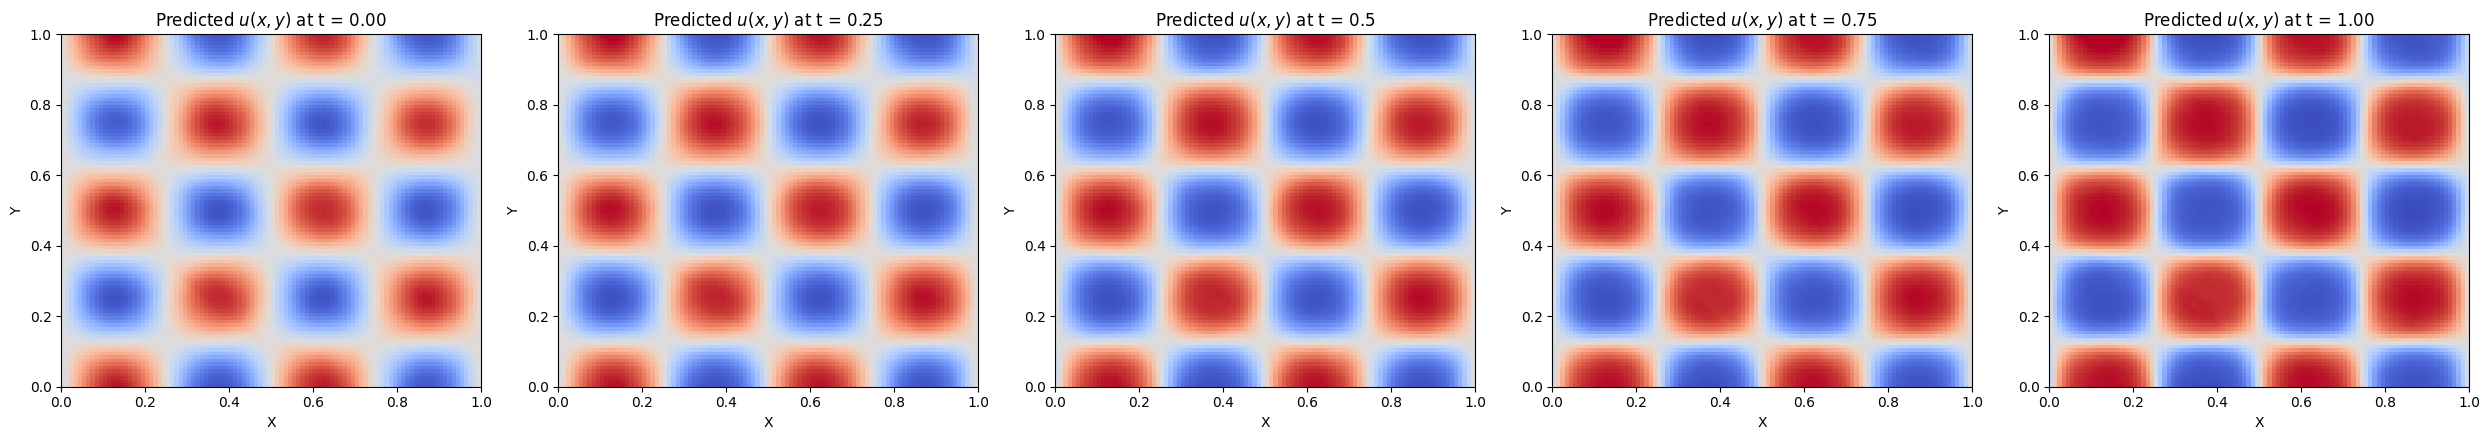

In [25]:
''' Solution Plot '''
plot_3d_solution_slices(u_pred, X, Y, T, lb, ub)

In [18]:
import re
import numpy as np
import tensorflow as tf

def load_weights_from_file(file_path, layers):
    """
    Loads weights and biases from a file saved by the train method.

    Args:
        file_path (str): The path to the file containing saved parameters.
        layers (list or np.ndarray): A list or array specifying the number of
                                     neurons in each layer, including input and output.

    Returns:
        tf.Tensor: A single flattened TensorFlow tensor containing the loaded weights
                   and biases, with dtype tf.float64.
    """
    loaded_params_np = []
    current_shape = None
    reading_data = False # Use a single flag for reading data lines
    data_lines_buffer = [] # Buffer to collect raw data lines

    def process_buffer():
        """Helper function to process collected raw data lines buffer."""
        nonlocal data_lines_buffer, current_shape, loaded_params_np, reading_data
        if data_lines_buffer and current_shape:
            all_numeric_strings = []
            # Join all lines in the buffer into a single string and split by whitespace
            full_data_string = " ".join(data_lines_buffer)
            all_numeric_strings = full_data_string.split()


            numeric_data = []
            for item in all_numeric_strings:
                try:
                    # Attempt to convert each string item to a float
                    numeric_data.append(float(item))
                except ValueError:
                    # If conversion fails, skip this item silently
                    pass

            if numeric_data:
                try:
                    # Convert the list of floats to a numpy array and reshape
                    # Check if the number of collected data points matches the expected size
                    expected_size = np.prod(current_shape)
                    if len(numeric_data) == expected_size:
                        param_array = np.array(numeric_data, dtype=np.float64).reshape(current_shape)
                        loaded_params_np.append(param_array.flatten()) # Flatten and append to numpy list
                    else:
                        print(f"Warning: Mismatch in data size for shape {current_shape}. Collected {len(numeric_data)} numbers, expected {expected_size}.")
                        # Optionally, try to append partially if it makes sense, but reshaping will fail
                        # For now, skip this block if size doesn't match
                except ValueError as e:
                    print(f"Error reshaping data for shape {current_shape}: {e}")
                except Exception as e:
                     print(f"An unexpected error occurred during numpy processing: {e}")
            else:
                 # This warning is helpful if a header was found but no numeric data followed
                 print(f"Warning: No valid numeric data found in buffer for shape {current_shape}.")


        data_lines_buffer = [] # Clear buffer after processing
        reading_data = False
        current_shape = None


    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line: # Skip empty lines
                continue

            # Check for header lines
            weights_match = re.search(r'Layer \d+ Weights \(Shape: \((.*?)\)\):', line)
            biases_match = re.search(r'Layer \d+ Biases \(Shape: \((.*?)\)\):', line)

            if weights_match or biases_match:
                process_buffer() # Process any pending data from previous block

                match = weights_match if weights_match else biases_match
                shape_str = match.group(1)
                try:
                    # Correctly handle shape strings like "1," or "64,64" by splitting and filtering empty strings
                    shape_components = [int(s) for s in shape_str.split(',') if s.strip()]
                    current_shape = tuple(shape_components)
                    reading_data = True # Start reading data lines
                except ValueError:
                     print(f"Warning: Could not parse shape from string: {shape_str}")
                     current_shape = None # Reset shape if parsing fails
                     reading_data = False # Stop reading data if shape is invalid

                continue # Move to the next line after processing a header

            elif line.startswith('-' * 50):
                process_buffer() # Process collected data for the block
                continue # Move to the next line after processing a separator
            elif reading_data:
                # Collect raw data lines into the buffer if currently reading a data block
                data_lines_buffer.append(line)


        # Process any remaining data after the loop finishes (for the last block)
        process_buffer()


    # Concatenate all flattened numpy arrays
    if loaded_params_np:
        flattened_params_np = np.concatenate(loaded_params_np, axis=0)
        # Convert the final numpy array to a TensorFlow tensor with float64 dtype
        flattened_params_tf = tf.constant(flattened_params_np, dtype=tf.float64)
    else:
        # Return an empty tensor if no parameters were loaded
        flattened_params_tf = tf.constant([], dtype=tf.float64)


    return flattened_params_tf

In [19]:
# Example usage:
# Make sure to replace 'params' with the actual filename if you changed it
# Also ensure 'layers' is defined and matches the structure of the saved model
file_path = os.path.join(os.getcwd(), 'params')

# Define the layers array, should match the one used for training
layers = np.array([3,64,64,64,64,64,64,1])

# Load the flattened parameters
loaded_params = load_weights_from_file(file_path, layers)

# Check the shape of the loaded parameters
print("Shape of loaded flattened parameters:", loaded_params.shape)
print("Number of loaded parameters:", loaded_params.shape[0])
#print("Expected number of parameters:", PINN.parameters)



# Check if loaded_params is empty before setting weights
if loaded_params.shape[0] == 0:
    print("\nError: No parameters were loaded from the file.")
    print("Please ensure the file '{}' exists and contains saved weights and biases in the correct format.".format(file_path))
else:
    # Create a new model instance or use the existing one
    # If you are continuing training or evaluating after a crash,
    # you might want to create a new instance and load weights.
    # If the previous training run completed and PINN is still in memory, you can use the existing PINN object.

    # Example of creating a new model instance (if needed)
    # new_PINN_model = Sequentialmodel(layers)

    # Set the weights of the model using the loaded parameters
    try:
        PINN.set_weights(loaded_params)
        print("Successfully loaded weights and biases into the model.")
    except NameError:
        print("Error: PINN object not found. Please ensure the PINN model is initialized before loading weights.")

Shape of loaded flattened parameters: (21121,)
Number of loaded parameters: 21121
Successfully loaded weights and biases into the model.
